In [1]:
import re
import math
import pandas as pd
import ast


In [2]:
import re
import math

def extract_tensor_values(sparsities_str):
    tensor_strings = sparsities_str.strip('()').split('), ')
    values = []
    for tensor_str in tensor_strings:
        match = re.search(r"tensor\(([\d.]+)", tensor_str)
        if match:
            values.append(float(match.group(1)))
    return values

# def get_linear_bops(in_features, out_features, sparsity, bit_width):
#     effective_connections = in_features * out_features * (1 - sparsity)
#     mult_bops = effective_connections * bit_width * bit_width
#     add_bops = effective_connections * (2 * bit_width + math.ceil(math.log2(in_features)))
#     return mult_bops + add_bops

def get_linear_bops(in_features, out_features, sparsity, bit_width=32):
    return out_features * in_features * (1 - sparsity) * (
         bit_width**2 + 2*bit_width + math.log2(in_features)
        
    )

def calculate_model_bops(model_name, phi_sparsities, rho_sparsities, bit_width):
    model_architectures = {
        'Large': {
            'phi': [(3, 32), (32, 32)],
            'rho': [(32, 32), (32, 64), (64, 5)]
        },
        'Medium': {
            'phi': [(3, 32), (32, 16)],
            'rho': [(16, 64), (64, 8), (8, 32), (32, 5)]
        },
        'Small': {
            'phi': [(3, 8), (8, 8)],
            'rho': [(8, 16), (16, 16), (16, 5)]
        },
        'Tiny': {
            'phi': [(3, 16)],
            'rho': [(16, 8), (8, 8), (8, 4), (4, 5)]
        }
    }

    #Deepsets original architecture
    Deepsets = {
        'phi': [(3, 32), (32, 32), (32, 32)],
        'rho': [(32, 16), (16, 5)]
    }


    architecture = model_architectures[model_name]
    total_bops = 0

    for (in_features, out_features), sparsity in zip(architecture['phi'], phi_sparsities):
        total_bops += get_linear_bops(in_features, out_features, sparsity, bit_width)*8

    for (in_features, out_features), sparsity in zip(architecture['rho'], rho_sparsities):
        total_bops += get_linear_bops(in_features, out_features, sparsity, bit_width)

    return total_bops


def calculate_original_deepsets_bops(bit_width=32):
    Deepsets = {
        'phi': [(3, 32), (32, 32), (32, 32)],
        'rho': [(32, 16), (16, 5)]
    }
    
    total_bops = 0
    
    for in_features, out_features in Deepsets['phi']:
        total_bops += get_linear_bops(in_features, out_features, sparsity=0, bit_width=bit_width)*8
    
    for in_features, out_features in Deepsets['rho']:
        total_bops += get_linear_bops(in_features, out_features, sparsity=0, bit_width=bit_width)
    
    return total_bops

# Calculate BOPs for the original Deepsets model
original_deepsets_bops = calculate_original_deepsets_bops(8)
print(f"Original Deepsets BOPs: {original_deepsets_bops:.2e}")


def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = {}
    for line in lines:
        match = re.match(r"Deepsets (\w+) Model (\d+)-Bit QAT Model Prune Iter: (\d+)", line)
        if match:
            model_name, bit_width, iteration = match.groups()
            full_model_name = f"Deepsets {model_name} Model {bit_width}-Bit QAT Model"
            
            if full_model_name not in data:
                data[full_model_name] = {
                    'model_name': [],
                    'bit_width': [],
                    'iteration': [],
                    'test_accuracy': [],
                    'val_accuracy': [],
                    'val_loss': [],
                    'phi_sparsities': [],
                    'rho_sparsities': [],
                    'total_bops': [],
                    'net sparsity': []
                }
            
            test_accuracy = float(re.search(r"Test Accuracy: ([\d.]+)", line).group(1))
            val_accuracy = float(re.search(r"Val Accuracy: ([\d.]+)", line).group(1))
            val_loss = float(re.search(r"Val Loss: ([\d.]+)", line).group(1))
            
            phi_sparsities_str = re.search(r"Phi Sparsities: (.*?) Rho Sparsities:", line).group(1)
            rho_sparsities_str = re.search(r"Rho Sparsities: (.*?)$", line).group(1)

            phi_sparsities = extract_tensor_values(phi_sparsities_str)
            rho_sparsities = extract_tensor_values(rho_sparsities_str)

            # Calculate BOPs
            total_bops = calculate_model_bops(model_name, phi_sparsities, rho_sparsities, int(bit_width))

            net_sparsity = 1- 0.8**int(iteration)

            # Append data to the respective lists
            data[full_model_name]['model_name'].append(model_name)
            data[full_model_name]['bit_width'].append(int(bit_width))
            data[full_model_name]['iteration'].append(int(iteration))
            data[full_model_name]['test_accuracy'].append(test_accuracy)
            data[full_model_name]['val_accuracy'].append(val_accuracy)
            data[full_model_name]['val_loss'].append(val_loss)
            data[full_model_name]['phi_sparsities'].append(phi_sparsities)
            data[full_model_name]['rho_sparsities'].append(rho_sparsities)
            data[full_model_name]['total_bops'].append(total_bops)

            data[full_model_name]['net sparsity'].append(net_sparsity)
            # print("phi_sparsities:", phi_sparsities, "rho_sparsities:", rho_sparsities)

            # print(f"model name: {model_name}, total_bops: {total_bops:.2e}, net sparsity: {net_sparsity:.4f}, bit width: {bit_width}")

    return data

file_path = './combined_deepsets_Compress_Aug7.txt'
extracted_data = extract_data(file_path)
# print(extracted_data.keys())


print(1.21e+07/1e6)



Original Deepsets BOPs: 1.51e+06
12.1


In [3]:
# print(4.93e+06/7.11e+04)
print(4.93e6/7.11e4)
print(1/(1-0.9856))

def bop_to_sparsity_ratio(model_name,data):
    model = data[model_name]
    first_BOP = model['total_bops'][0]
    last_BOP = model['total_bops'][-1]
    last_sparsity = model['net sparsity'][-1]
    # print(f'first bop: {first_BOP:.2e}, last bop: {last_BOP:.2e}, last sparsity: {last_sparsity:.4f}')

    BOP_ratio = first_BOP/last_BOP
    sparsity_ratio = 1/(1-last_sparsity)

    print(f"for {model_name} BOPs decrease by a factor of {BOP_ratio:.4f} and sparsity increases by a factor of {sparsity_ratio:.4f}")

    # print(f"Model: {model_name}, BOP Ratio: {BOP_ratio:.4f}, Sparsity Ratio: {sparsity_ratio:.4f}")

large_model32= 'Deepsets Large Model 32-Bit QAT Model'
large_model8= 'Deepsets Large Model 8-Bit QAT Model'
medium_model32= 'Deepsets Medium Model 32-Bit QAT Model'
medium_model8= 'Deepsets Medium Model 8-Bit QAT Model'
small_model32= 'Deepsets Small Model 32-Bit QAT Model'
small_model16= 'Deepsets Small Model 16-Bit QAT Model'

# bop_to_sparsity_ratio(large_model32,extracted_data)
# bop_to_sparsity_ratio(large_model8,extracted_data)
# bop_to_sparsity_ratio(medium_model32,extracted_data)
# bop_to_sparsity_ratio(medium_model8,extracted_data)
# bop_to_sparsity_ratio(small_model32,extracted_data)
# bop_to_sparsity_ratio(small_model16,extracted_data)


# med_8bit = extracted_data['Deepsets Medium Model 8-Bit QAT Model']
med_8bit = extracted_data[medium_model8]
lar_8bit = extracted_data[large_model8]
small_8bit = extracted_data[small_model16]
tiny_8bit = extracted_data['Deepsets Tiny Model 8-Bit QAT Model']


# print(med_8bit.keys())
# for keys in med_8bit.keys():
#     print(keys, med_8bit[keys][0])
#     # Calculate the BOP to sparsity ratio for the medium model
#     bop_to_sparsity_ratio(medium_model8, extracted_data)

for keys in lar_8bit.keys():
    print(keys, lar_8bit[keys][0])

print("----------------------------------")

for keys in small_8bit.keys():
    print(keys, small_8bit[keys][0])

print("----------------------------------")

for keys in tiny_8bit.keys():
    print(keys, tiny_8bit[keys][0])

69.33895921237693
69.4444444444446
model_name Large
bit_width 8
iteration 0
test_accuracy 0.6541689783625267
val_accuracy 0.6570713162688938
val_loss 0.8991013980236183
phi_sparsities [0.0, 0.0]
rho_sparsities [0.0, 0.0, 0.0]
total_bops 1047617.2512005538
net sparsity 0.0
----------------------------------
model_name Small
bit_width 16
iteration 0
test_accuracy 0.6254379012443528
val_accuracy 0.6268710850088595
val_loss 0.9738271041792266
phi_sparsities [0.0, 0.0]
rho_sparsities [0.0, 0.0, 0.0]
total_bops 339952.3128001385
net sparsity 0.0
----------------------------------
model_name Tiny
bit_width 8
iteration 0
test_accuracy 0.606075136720298
val_accuracy 0.6076415635840314
val_loss 1.0235433732571244
phi_sparsities [0.0]
rho_sparsities [0.0, 0.0, 0.0, 0.0]
total_bops 51688.62560027692
net sparsity 0.0


Model: Large 32-Bit, Shape: hexagon, Color: #1F271B
Model: Large 16-Bit, Shape: pentagon, Color: #1F271B
Model: Large 8-Bit, Shape: square, Color: #1F271B
Model: Large 4-Bit, Shape: triangle, Color: #1F271B
Model: Medium 32-Bit, Shape: hexagon, Color: #19647E
Model: Medium 16-Bit, Shape: pentagon, Color: #19647E
Model: Medium 8-Bit, Shape: square, Color: #19647E
Model: Medium 4-Bit, Shape: triangle, Color: #19647E
Model: Small 32-Bit, Shape: hexagon, Color: #28AFB0
Model: Small 16-Bit, Shape: pentagon, Color: #28AFB0
Model: Small 8-Bit, Shape: square, Color: #28AFB0
Model: Small 4-Bit, Shape: triangle, Color: #28AFB0
Model: Tiny 32-Bit, Shape: hexagon, Color: #F4D35E
Model: Tiny 16-Bit, Shape: pentagon, Color: #F4D35E
Model: Tiny 8-Bit, Shape: square, Color: #F4D35E
Model: Tiny 4-Bit, Shape: triangle, Color: #F4D35E
Plot saved as ./plots/BOPs_vs_Accuracy_shapes.pdf


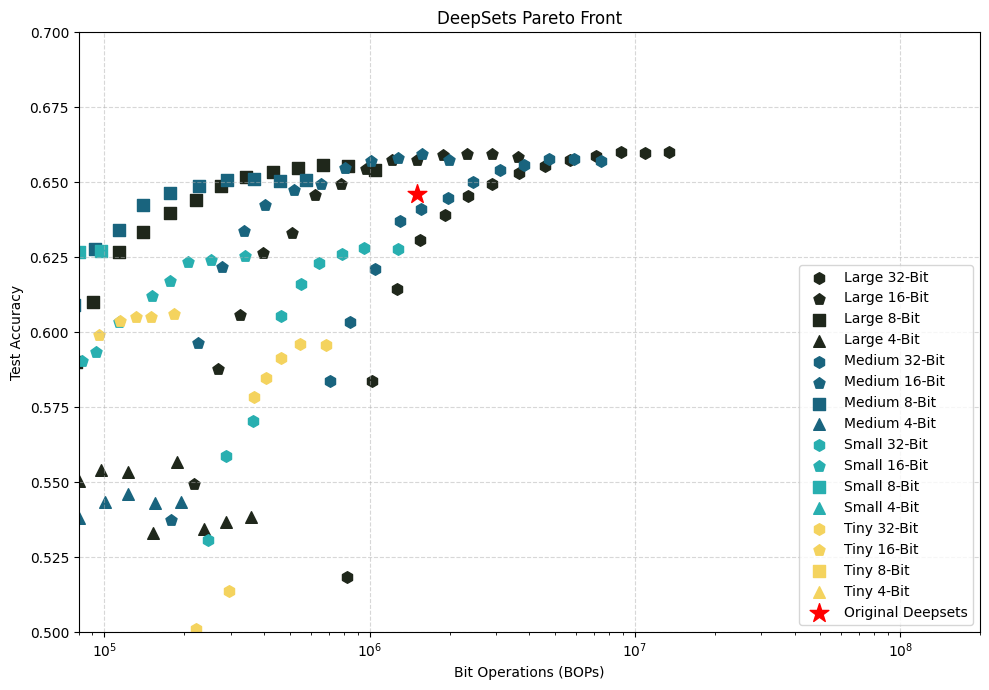

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

def plot_bops_vs_accuracy(data, output_folder='./plots'):
    plt.figure(figsize=(10, 7))
    
    # Define the order of models from smallest to largest
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    
    color_families = {
        'Tiny': '#F4D35E',
        'Small': '#28AFB0',
        'Medium': '#19647E',
        'Large': '#1F271B'
    }

    # Define shapes for different bit widths
    bit_width_shapes = {
        4: 'triangle',
        8: 'square',
        16: 'pentagon',
        32: 'hexagon'
    }

    for full_model_name, model_data in data.items():
        # Extract model size and bit width from the full model name
        match = re.match(r"Deepsets (\w+) Model (\d+)-Bit QAT Model", full_model_name)
        if match:
            model_size, bit_width = match.groups()
            bit_width = int(bit_width)

            if model_size in model_order:
                model_name = f'{model_size} {bit_width}-Bit'
                
                # Use the base color for the model size
                color = color_families[model_size]
                
                # Use shape based on bit width
                shape = bit_width_shapes[bit_width]
                print(f"Model: {model_name}, Shape: {shape}, Color: {color}")
                
                if shape == 'triangle':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='^', color=color, s=70)
                elif shape == 'square':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='s', color=color, s=70)
                elif shape == 'pentagon':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='p', color=color, s=70)
                elif shape == 'hexagon':
                    plt.scatter(model_data['total_bops'], model_data['test_accuracy'], 
                                label=model_name, marker='h', color=color, s=70)


    # Add the original Deepsets model point
    original_deepsets_bops = calculate_original_deepsets_bops(8)
    plt.scatter(original_deepsets_bops, 0.646, label='Original Deepsets', 
                marker='*', color='red', s=200, zorder=5)

    plt.xscale('log') 
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('DeepSets Pareto Front')
    plt.legend(loc='lower right')  # Move the legend to the lower right
    plt.grid(True, which="major", ls="--", alpha=0.5)
    plt.xlim(8e4,2e8)
    plt.ylim(0.5, 0.7)
    
    plt.tight_layout()
    plt.savefig(f'{output_folder}/BOPs_vs_Accuracy_coloredSep2.pdf', dpi=300, bbox_inches='tight')
    print(f"Plot saved as {output_folder}/BOPs_vs_Accuracy_shapes.pdf")
    
    plt.show()
extracted_data = extract_data(file_path)
plot_bops_vs_accuracy(extracted_data)


#Change the color scheme to be these colors instead: 353535, 6d597a, e56b6f, eaac8b